<a id="section-one"></a>
## 1 Import Libraries and download data

<a id="define-device"></a>
### 1.2 Define device

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 9-AR

In [71]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import MinMaxScaler
np.random.seed(2021)

def categorize_time_of_day(hour):
    if 0 <= hour < 4:
        return 'Early Morning'
    elif 4 <= hour < 7:
        return 'Morning'
    elif 7 <= hour < 10:
        return 'Late Morning'
    elif 10 <= hour < 12:
        return 'Noon'
    elif 12 <= hour < 14:
        return 'Afternoon'

    elif 14 <= hour < 17:
        return 'Evening'
    elif 17 <= hour < 19:
        return 'Night'
    elif 19 <= hour < 22:
        return 'Late Night'
    else:
        return 'Too Late Night'




"""
!wget http://casas.wsu.edu/datasets/hh101.zip
!wget http://casas.wsu.edu/datasets/hh105.zip
!wget http://casas.wsu.edu/datasets/hh104.zip
!wget http://casas.wsu.edu/datasets/hh103.zip
!unzip '/content/hh103.zip'
!unzip '/content/hh104.zip'
!unzip '/content/hh105.zip'
!unzip /content/hh101.zip
"""

Final_Data_S1 = pd.read_csv("/content/hh101/hh101.ann.features.csv")
Final_Data_S2 = pd.read_csv("/content/hh105/hh105.ann.features.csv")
Final_Data_S3 = pd.read_csv("/content/hh104/hh104.ann.features.csv")
Final_Data_S4 = pd.read_csv("/content/hh103/hh103.ann.features.csv")

Final_Data_S1.rename(columns={"activity": "labels"}, inplace= True)
Final_Data_S2.rename(columns={"activity": "labels"}, inplace= True)
Final_Data_S3.rename(columns={"activity": "labels"}, inplace= True)
Final_Data_S4.rename(columns={"activity": "labels"}, inplace= True)

# Add the time_of_day feature to each dataset
for df in [Final_Data_S1, Final_Data_S2, Final_Data_S3, Final_Data_S4]:
    df['time_of_day'] = df['lastSensorEventHours'].apply(categorize_time_of_day)

# Convert categorical feature to numerical encoding (if needed for ML models)
time_of_day_mapping = {
    'Early Morning': 1,
    'Morning': 2,
    'Late Morning': 3,
    'Noon': 4,
    'Afternoon': 5,
    'Evening': 6,
    'Night': 7,
    'Late Night': 8,
    'Too Late Night': 9
}
for df in [Final_Data_S1, Final_Data_S2, Final_Data_S3, Final_Data_S4]:
    df['time_of_day'] = df['time_of_day'].map(time_of_day_mapping)



Final_Data_S1 = Final_Data_S1.drop(['lastSensorEventHours', 'lastSensorEventSeconds', 'lastSensorDayOfWeek','lastSensorID'], axis= 1)
Final_Data_S2 = Final_Data_S2.drop(['lastSensorEventHours', 'lastSensorEventSeconds','lastSensorDayOfWeek', 'lastSensorID'], axis= 1)
Final_Data_S3 = Final_Data_S3.drop(['lastSensorEventHours', 'lastSensorEventSeconds', 'lastSensorDayOfWeek','lastSensorID'], axis= 1)
Final_Data_S4 = Final_Data_S4.drop(['lastSensorEventHours', 'lastSensorEventSeconds','lastSensorDayOfWeek', 'lastSensorID'], axis= 1)



def preprocess_data(df):
    # 1. Cyclic Encoding for Temporal Features
    df['windowDuration_sin'] = np.sin(2 * np.pi * df['windowDuration'] / 1440)  # Assuming minutes in a day
    df['windowDuration_cos'] = np.cos(2 * np.pi * df['windowDuration'] / 1440)
    df['timeSinceLastSensorEvent_sin'] = np.sin(2 * np.pi * df['timeSinceLastSensorEvent'] / 1440)
    df['timeSinceLastSensorEvent_cos'] = np.cos(2 * np.pi * df['timeSinceLastSensorEvent'] / 1440)

    # 2. Normalize Sensor Features (Ratios)
    sensor_cols = [col for col in df.columns if 'sensorCount' in col]
    time_cols = [col for col in df.columns if 'sensorElTime' in col]

    df['total_sensor_count'] = df[sensor_cols].sum(axis=1) + 1e-6  # Avoid division by zero
    df['total_sensor_time'] = df[time_cols].sum(axis=1) + 1e-6

    for col in sensor_cols:
        df[f'{col}_ratio'] = df[col] / df['total_sensor_count']
    for col in time_cols:
        df[f'{col}_ratio'] = df[col] / df['total_sensor_time']

    df.drop(columns=['total_sensor_count', 'total_sensor_time'], inplace=True)  # Drop intermediate columns

    # 3. Normalize Movement Features
    scaler = MinMaxScaler()
    df[['complexity', 'activityChange', 'areaTransitions']] = scaler.fit_transform(
        df[['complexity', 'activityChange', 'areaTransitions']]
    )

    # 4. Interaction Feature: Complexity × Activity Change
    df['complexity_activityChange'] = df['complexity'] * df['activityChange']

    # 5. Binary Feature: Sensor Location Change
    df['location_change'] = (df['lastSensorLocation'] != df['lastMotionLocation']).astype(int)

    # 6. Drop Redundant Features
    df.drop(columns=['lastSensorLocation', 'lastMotionLocation'], inplace=True)

    return df

# Apply preprocessing to all datasets



Final_Data_S1 = Final_Data_S1[Final_Data_S1.labels.isin(['Cook_Dinner', 'Cook_Breakfast', 'Cook_Lunch', 'Eat', 'Toilet', 'Bathe', 'Sleep', 'Relax', 'Dress'  ])]
Final_Data_S2 = Final_Data_S2[Final_Data_S2.labels.isin(['Cook_Dinner', 'Cook_Breakfast', 'Cook_Lunch', 'Eat', 'Toilet', 'Bathe', 'Sleep', 'Relax', 'Dress'   ])]
Final_Data_S3 = Final_Data_S3[Final_Data_S3.labels.isin(['Cook_Dinner', 'Cook_Breakfast', 'Cook_Lunch', 'Eat', 'Toilet', 'Bathe', 'Sleep', 'Relax', 'Dress'  ])]
Final_Data_S4 = Final_Data_S4[Final_Data_S4.labels.isin(['Cook_Dinner', 'Cook_Breakfast', 'Cook_Lunch', 'Eat', 'Toilet', 'Bathe', 'Sleep' , 'Relax', 'Dress'  ])]

Final_Data_S1.loc[Final_Data_S1[Final_Data_S1.labels.isin(['Eat'])].index,'labels']=0
Final_Data_S1.loc[Final_Data_S1[Final_Data_S1.labels.isin(['Cook_Lunch'])].index,'labels']=1
Final_Data_S1.loc[Final_Data_S1[Final_Data_S1.labels.isin(['Toilet'])].index,'labels']=2
Final_Data_S1.loc[Final_Data_S1[Final_Data_S1.labels.isin(['Cook_Breakfast'])].index,'labels']=3
Final_Data_S1.loc[Final_Data_S1[Final_Data_S1.labels.isin(['Cook_Dinner'])].index,'labels']=4
Final_Data_S1.loc[Final_Data_S1[Final_Data_S1.labels.isin(['Bathe'])].index,'labels']=5
Final_Data_S1.loc[Final_Data_S1[Final_Data_S1.labels.isin(['Sleep'])].index,'labels']=6
Final_Data_S1.loc[Final_Data_S1[Final_Data_S1.labels.isin(['Relax'])].index,'labels']=7
Final_Data_S1.loc[Final_Data_S1[Final_Data_S1.labels.isin(['Dress'])].index,'labels']=8


Final_Data_S2.loc[Final_Data_S2[Final_Data_S2.labels.isin(['Eat'])].index,'labels']=0
Final_Data_S2.loc[Final_Data_S2[Final_Data_S2.labels.isin(['Cook_Lunch'])].index,'labels']=1
Final_Data_S2.loc[Final_Data_S2[Final_Data_S2.labels.isin(['Toilet'])].index,'labels']=2
Final_Data_S2.loc[Final_Data_S2[Final_Data_S2.labels.isin(['Cook_Breakfast'])].index,'labels']=3
Final_Data_S2.loc[Final_Data_S2[Final_Data_S2.labels.isin(['Cook_Dinner'])].index,'labels']=4
Final_Data_S2.loc[Final_Data_S2[Final_Data_S2.labels.isin(['Bathe'])].index,'labels']=5
Final_Data_S2.loc[Final_Data_S2[Final_Data_S2.labels.isin(['Sleep'])].index,'labels']=6
Final_Data_S2.loc[Final_Data_S2[Final_Data_S2.labels.isin(['Relax'])].index,'labels']=7
Final_Data_S2.loc[Final_Data_S2[Final_Data_S2.labels.isin(['Dress'])].index,'labels']=8

Final_Data_S3.loc[Final_Data_S3[Final_Data_S3.labels.isin(['Eat'])].index,'labels']=0
Final_Data_S3.loc[Final_Data_S3[Final_Data_S3.labels.isin(['Cook_Lunch'])].index,'labels']=1
Final_Data_S3.loc[Final_Data_S3[Final_Data_S3.labels.isin(['Toilet'])].index,'labels']=2
Final_Data_S3.loc[Final_Data_S3[Final_Data_S3.labels.isin(['Cook_Breakfast'])].index,'labels']=3
Final_Data_S3.loc[Final_Data_S3[Final_Data_S3.labels.isin(['Cook_Dinner'])].index,'labels']=4
Final_Data_S3.loc[Final_Data_S3[Final_Data_S3.labels.isin(['Bathe'])].index,'labels']=5
Final_Data_S3.loc[Final_Data_S3[Final_Data_S3.labels.isin(['Sleep'])].index,'labels']=6
Final_Data_S3.loc[Final_Data_S3[Final_Data_S3.labels.isin(['Relax'])].index,'labels']=7
Final_Data_S3.loc[Final_Data_S3[Final_Data_S3.labels.isin(['Dress'])].index,'labels']=8


Final_Data_S4.loc[Final_Data_S4[Final_Data_S4.labels.isin(['Eat'])].index,'labels']=0
Final_Data_S4.loc[Final_Data_S4[Final_Data_S4.labels.isin(['Cook_Lunch'])].index,'labels']=1
Final_Data_S4.loc[Final_Data_S4[Final_Data_S4.labels.isin(['Toilet'])].index,'labels']=2
Final_Data_S4.loc[Final_Data_S4[Final_Data_S4.labels.isin(['Cook_Breakfast'])].index,'labels']=3
Final_Data_S4.loc[Final_Data_S4[Final_Data_S4.labels.isin(['Cook_Dinner'])].index,'labels']=4
Final_Data_S4.loc[Final_Data_S4[Final_Data_S4.labels.isin(['Bathe'])].index,'labels']=5
Final_Data_S4.loc[Final_Data_S4[Final_Data_S4.labels.isin(['Sleep'])].index,'labels']=6
Final_Data_S4.loc[Final_Data_S4[Final_Data_S4.labels.isin(['Relax'])].index,'labels']=7
Final_Data_S4.loc[Final_Data_S4[Final_Data_S4.labels.isin(['Dress'])].index,'labels']=8

Data_0 = Final_Data_S1[Final_Data_S1.labels == 0].iloc[:4000]#2000#4000
Data_1 = Final_Data_S1[Final_Data_S1.labels == 1].iloc[:4000]#4000
Data_2 = Final_Data_S1[Final_Data_S1.labels == 2].iloc[:4000]#2000
Data_3 = Final_Data_S1[Final_Data_S1.labels == 3].iloc[:4000]#4000
Data_4 = Final_Data_S1[Final_Data_S1.labels == 4].iloc[:4000]
Data_5 = Final_Data_S1[Final_Data_S1.labels == 5].iloc[:4000]#4000
Data_6 = Final_Data_S1[Final_Data_S1.labels == 6].iloc[:4000]
Data_7 = Final_Data_S1[Final_Data_S1.labels == 7].iloc[:4000]#4000
Data_8 = Final_Data_S1[Final_Data_S1.labels == 8].iloc[:4000]


frames = [Data_0, Data_1, Data_2, Data_3, Data_4, Data_5, Data_6, Data_7, Data_8]
Final_Data_S1 = pd.concat(frames)

Data_0 = Final_Data_S3[Final_Data_S3.labels == 0].iloc[:4000]#2000#4000
Data_1 = Final_Data_S3[Final_Data_S3.labels == 1].iloc[:4000]#4000
Data_2 = Final_Data_S3[Final_Data_S3.labels == 2].iloc[:2000]#2000
Data_3 = Final_Data_S3[Final_Data_S3.labels == 3].iloc[:2000]#4000
Data_4 = Final_Data_S3[Final_Data_S3.labels == 4].iloc[:2000]#
Data_5 = Final_Data_S3[Final_Data_S3.labels == 5].iloc[:2000]#4000
Data_6 = Final_Data_S3[Final_Data_S3.labels == 6].iloc[:2000]#
Data_7 = Final_Data_S3[Final_Data_S3.labels == 7].iloc[:2000]#
Data_8 = Final_Data_S3[Final_Data_S3.labels == 8].iloc[:2000]



frames = [Data_0, Data_1, Data_2, Data_3, Data_4, Data_5, Data_6, Data_7, Data_8]
Final_Data_S3 = pd.concat(frames)


Data_0 = Final_Data_S4[Final_Data_S4.labels == 0].iloc[:4000]#2000#4000
Data_1 = Final_Data_S4[Final_Data_S4.labels == 1].iloc[:4000]#4000
Data_2 = Final_Data_S4[Final_Data_S4.labels == 2].iloc[:2000]#2000
Data_3 = Final_Data_S4[Final_Data_S4.labels == 3].iloc[:2000]#4000
Data_4 = Final_Data_S4[Final_Data_S4.labels == 4].iloc[:2000]#
Data_5 = Final_Data_S4[Final_Data_S4.labels == 5].iloc[:2000]#
Data_6 = Final_Data_S4[Final_Data_S4.labels == 6].iloc[:2000]#
Data_7 = Final_Data_S4[Final_Data_S4.labels == 7].iloc[:2000]#
Data_8 = Final_Data_S4[Final_Data_S4.labels == 8].iloc[:2000]


frames = [Data_0, Data_1, Data_2, Data_3, Data_4, Data_5, Data_6, Data_7, Data_8]
Final_Data_S4 = pd.concat(frames)

Data_0 = Final_Data_S2[Final_Data_S2.labels == 0].iloc[:100]#1000#2000
Data_1 = Final_Data_S2[Final_Data_S2.labels == 1].iloc[:100]#2000
Data_2 = Final_Data_S2[Final_Data_S2.labels == 2].iloc[:100]#
Data_3 = Final_Data_S2[Final_Data_S2.labels == 3].iloc[:100]#2000
Data_4 = Final_Data_S2[Final_Data_S2.labels == 4].iloc[:100]#
Data_5 = Final_Data_S2[Final_Data_S2.labels == 5].iloc[:100]#
Data_6 = Final_Data_S2[Final_Data_S2.labels == 6].iloc[:100]#
Data_7 = Final_Data_S2[Final_Data_S2.labels == 7].iloc[:100]#
Data_8 = Final_Data_S2[Final_Data_S2.labels == 8].iloc[:100]

frames = [Data_0, Data_1, Data_2, Data_3, Data_4, Data_5, Data_6, Data_7, Data_8]
Final_Data_S2 = pd.concat(frames)


Final_Data_S1 = Final_Data_S1.sample(frac = 1)
Final_Data_S2 = Final_Data_S2.sample(frac = 1)
Final_Data_S4 = Final_Data_S4.sample(frac = 1)
Final_Data_S3 = Final_Data_S3.sample(frac = 1)

#Final_Data_S1 = preprocess_data(Final_Data_S1)
#Final_Data_S2 = preprocess_data(Final_Data_S2)
#Final_Data_S3 = preprocess_data(Final_Data_S3)
#Final_Data_S4 = preprocess_data(Final_Data_S4)


Source_train_1 = Final_Data_S1.iloc[200:,:]#200#
Source_test_1 = Final_Data_S1.iloc[:200,:]

Source_train_2 = Final_Data_S4.iloc[200:,:]#200#
Source_test_2 = Final_Data_S4.iloc[:200,:]

Source_train_3 = Final_Data_S3.iloc[200:,:]#200#
Source_test_3 = Final_Data_S3.iloc[:200,:]


Target_train = Final_Data_S2.iloc[873:,:]
Target_test = Final_Data_S2.iloc[:873,:]




Source_train_1.to_csv('/content/drive/MyDrive/FAS2AR/data/Source_train_1.csv', index=False)
Source_test_1.to_csv('/content/drive/MyDrive/FAS2AR/data/Source_test_1.csv', index=False)

Source_train_2.to_csv('/content/drive/MyDrive/FAS2AR/data/Source_train_2.csv', index=False)
Source_test_2.to_csv('/content/drive/MyDrive/FAS2AR/data/Source_test_2.csv', index=False)

Source_train_3.to_csv('/content/drive/MyDrive/FAS2AR/data/Source_train_3.csv', index=False)
Source_test_3.to_csv('/content/drive/MyDrive/FAS2AR/data/Source_test_3.csv', index=False)


Target_train.to_csv('/content/drive/MyDrive/FAS2AR/data/Target_train.csv', index=False)
Target_test.to_csv('/content/drive/MyDrive/FAS2AR/data/Target_test.csv', index=False)

In [72]:
import os
os.chdir('/content/drive/MyDrive/FAS2AR/')

In [ ]:
!python main.py

Using device: cuda
Pre-training the embedding network (source domain)...
Starting pre-training on source data...
Epoch [1/10] Loss: 1.3445
Epoch [2/10] Loss: 1.0094
Epoch [3/10] Loss: 0.8178
Epoch [4/10] Loss: 0.7156
Epoch [5/10] Loss: 0.6391
Epoch [6/10] Loss: 0.6002
Epoch [7/10] Loss: 0.5646
Epoch [8/10] Loss: 0.5147
Epoch [9/10] Loss: 0.5041
Epoch [10/10] Loss: 0.4825
Pre-training complete.

Performing few-shot adaptation (target domain)...
Starting few-shot adaptation on target data...
Adaptation Epoch [1/300] Loss: 3.1853
Adaptation Epoch [2/300] Loss: 2.7934
Adaptation Epoch [3/300] Loss: 2.5089
Adaptation Epoch [4/300] Loss: 2.3980
Adaptation Epoch [5/300] Loss: 2.3339
Adaptation Epoch [6/300] Loss: 1.8118
Adaptation Epoch [7/300] Loss: 1.9556
Adaptation Epoch [8/300] Loss: 1.6004
Adaptation Epoch [9/300] Loss: 1.5411
Adaptation Epoch [10/300] Loss: 1.5079
Adaptation Epoch [11/300] Loss: 1.3171
Adaptation Epoch [12/300] Loss: 1.1585
Adaptation Epoch [13/300] Loss: 1.2127
Adaptat

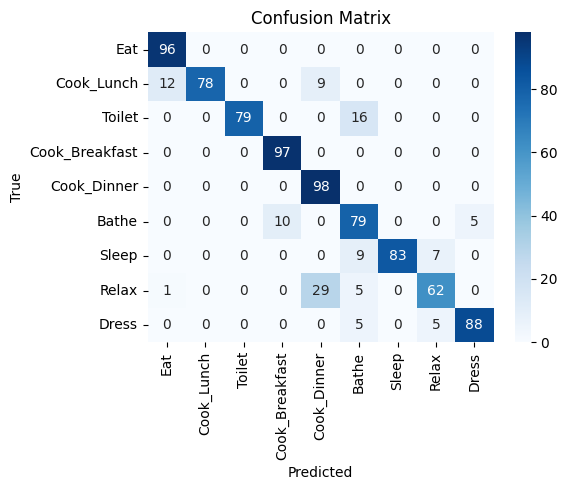

(0.8143537742814384, 0.870561282932417, 0.8706812875251198)

In [73]:
import torch
from train import pretrain_embedding, few_shot_adaptation, evaluate
from dataset import SensorDataset
import random
import numpy as np

def fix_seed(seed=2):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    # Ensure deterministic behavior for CuDNN backend
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

fix_seed(2)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

class_names = [
"Eat", "Cook_Lunch", "Toilet", "Cook_Breakfast",
"Cook_Dinner", "Bathe", "Sleep", "Relax", "Dress"
]

# ------------------------------
# 1. Pre-train Embedding Network
# ------------------------------
print("Pre-training the embedding network (source domain)...")
embedding_model, num_classes = pretrain_embedding(epochs=10, batch_size=32, learning_rate=1e-3, device=device)

# ------------------------------
# 2. Few-Shot Adaptation with HAESAR
# ------------------------------
print("Performing few-shot adaptation (target domain)...")
adapter = few_shot_adaptation(
    embedding_model,
    num_classes,
    epochs=300,
    batch_size=8,
    learning_rate=1e-3,
    alpha=0.01,
    lambda_adv=0.5,
    device=device
)

# ------------------------------
# 3. Evaluation
# ------------------------------
target_test_path  = "/content/drive/MyDrive/FAS2AR/data/Target_test.csv"
target_dataset = SensorDataset(target_test_path)
print("Evaluating the adapted model on target data...")
evaluate(embedding_model, adapter, target_dataset, batch_size=16, device=device,
class_names=class_names, plot_confusion=True)

Performing few-shot adaptation (target domain)...
Starting few-shot adaptation on target data...
Adaptation Epoch [1/100] Loss: 20.8249
Adaptation Epoch [2/100] Loss: 10.7693
Adaptation Epoch [3/100] Loss: 3.1866
Adaptation Epoch [4/100] Loss: 2.4651
Adaptation Epoch [5/100] Loss: 5.9108
Adaptation Epoch [6/100] Loss: 1.1148
Adaptation Epoch [7/100] Loss: 3.3063
Adaptation Epoch [8/100] Loss: 0.6804
Adaptation Epoch [9/100] Loss: 2.4246
Adaptation Epoch [10/100] Loss: 0.2886
Adaptation Epoch [11/100] Loss: 0.2673
Adaptation Epoch [12/100] Loss: 0.2304
Adaptation Epoch [13/100] Loss: 0.3926
Adaptation Epoch [14/100] Loss: 0.1279
Adaptation Epoch [15/100] Loss: 0.1370
Adaptation Epoch [16/100] Loss: 0.1886
Adaptation Epoch [17/100] Loss: 0.1311
Adaptation Epoch [18/100] Loss: 0.0852
Adaptation Epoch [19/100] Loss: 0.0774
Adaptation Epoch [20/100] Loss: 0.0866
Adaptation Epoch [21/100] Loss: 0.0629
Adaptation Epoch [22/100] Loss: 0.1012
Adaptation Epoch [23/100] Loss: 0.0510
Adaptation Ep

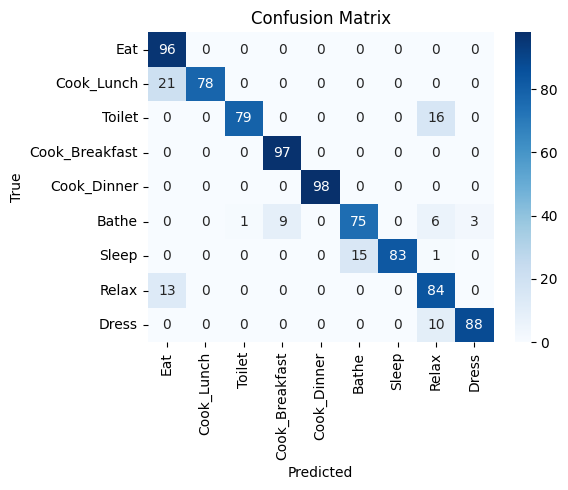

(1.3794762265376688, 0.8911798396334479, 0.8930339351906896)

In [74]:
import torch
from train import pretrain_embedding, few_shot_adaptation, evaluate
from dataset import SensorDataset
import random
import numpy as np

def fix_seed(seed=2):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    # Ensure deterministic behavior for CuDNN backend
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

fix_seed(2)

# ------------------------------
# 2. Few-Shot Adaptation with HAESAR
# ------------------------------
print("Performing few-shot adaptation (target domain)...")
adapter = few_shot_adaptation(
    embedding_model,
    num_classes,
    epochs=100,
    batch_size=8,
    learning_rate=1e-1,
    alpha=0.01,
    lambda_adv=0.5,
    device=device
)

# ------------------------------
# 3. Evaluation
# ------------------------------
target_test_path  = "/content/drive/MyDrive/FAS2AR/data/Target_test.csv"
target_dataset = SensorDataset(target_test_path)
print("Evaluating the adapted model on target data...")
evaluate(embedding_model, adapter, target_dataset, batch_size=16, device=device,
class_names=class_names, plot_confusion=True)